In [89]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import pymssql
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
import datetime
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import seaborn as sns
warnings.filterwarnings("ignore")
import requests
import json
import random
from tqdm import tqdm

In [119]:
#SQL QUERY 
def SQL_(movie_list=[], cinema=0, halls=[], tech=-1, premiere=False):
    
        
    p1=[]
    p2=[]
    p3=[]
    p4=[]
    if len(movie_list)!=0:
        p1=f' AllFilms.longID in {movie_list} '  
    if cinema!=0:
        p1=p1+'and'+f' AllFilms.Cinema ={cinema} ' 
    if len(halls)!=0:
        p1=p1+'and'+f' AllFilms.Halls in {halls} '
    if tech!=-1:
        p1=p1+'and'+f' AllFilms.TehCode in {tech} '
    
    query="""    select
sum(AllFilms.CountID) as 'CountID',
AllFilms.movie_code,
AllFilms.longID,
AllFilms.DATA,
AllFilms.TIMER,
AllFilms.TehCode,
AllFilms.Cinema,
AllFilms.Seats,
AllFilms.sessiond,
AllFilms.Halls
from
(
select 
count((KClients._Code)) as CountID,
KMovie._Code as movie_code,
KMovie._Fld13528 as longID,
cast( dateadd(year,-2000,KVisiting._Fld13867 ) as date) as DATA,
datepart(hour,KSession._Fld13203) as TIMER,
KTechnology._EnumOrder+1 as TehCode,
KCinema._Code as  Cinema,
KAuditorium._Fld4955 as Seats,
KSession._Number as sessiond,
KAuditorium._Code as Halls
from [KIS_AccumRg13714-from2017] as KVisiting
join KIS_Reference181 as KClients  on KClients._IDRRef=KVisiting._Fld13717RRef
join  KIS_Document13058 as KSession on KVisiting._Fld13715RRef=KSession._IDRRef
join KIS_Reference265 as KMovie on KSession._Fld13219RRef=KMovie._IDRRef
left join [KIS_Enum651] as KTechnology on KSession.[_Fld13217RRef]=KTechnology.[_IDRRef]   
left join [KIS_Reference267] as KAuditorium on KSession.[_Fld13213RRef]=KAuditorium.[_IDRRef]                                   
left join [KIS_Reference222]  as KCinema on KAuditorium.[_OwnerIDRRef]=KCinema.[_IDRRef] 


                                 
group by 
KMovie._Code,
KMovie._Fld13528 ,
cast( dateadd(year,-2000,KVisiting._Fld13867 ) as date),
datepart(hour,KSession._Fld13203),
KTechnology._EnumOrder,
KCinema._Code, KAuditorium._Fld4955 ,KAuditorium._Code,KSession._Number
union all
select 
count((KClients._Code)) as CountID,
KMovie._Code as movie_code,
KMovie._Fld13528 as longID,
cast( dateadd(year,-2000,KVisiting._Fld13867 ) as date) as DATA,
datepart(hour,KSession._Fld13203) as TIMER,
KTechnology._EnumOrder+1 as TehCode,
KCinema._Code as  Cinema,
KAuditorium._Fld4955 as Seats,
KSession._Number as sessiond,
KAuditorium._Code as Halls
from [KIS_AccumRg13714-to2017] as KVisiting
join KIS_Reference181 as KClients  on KClients._IDRRef=KVisiting._Fld13717RRef
join  KIS_Document13058 as KSession on KVisiting._Fld13715RRef=KSession._IDRRef
join KIS_Reference265 as KMovie on KSession._Fld13219RRef=KMovie._IDRRef
left join [KIS_Enum651] as KTechnology on KSession.[_Fld13217RRef]=KTechnology.[_IDRRef]   
left join [KIS_Reference267] as KAuditorium on KSession.[_Fld13213RRef]=KAuditorium.[_IDRRef]                                   
left join [KIS_Reference222]  as KCinema on KAuditorium.[_OwnerIDRRef]=KCinema.[_IDRRef]   
                                  
group by 
KMovie._Code,
KMovie._Fld13528 ,
cast( dateadd(year,-2000,KVisiting._Fld13867 ) as date),
datepart(hour,KSession._Fld13203),
KTechnology._EnumOrder,
KCinema._Code, KAuditorium._Fld4955 ,KAuditorium._Code,KSession._Number
) as AllFilms
where""" 
    
    query2= """ 
group by AllFilms.movie_code,
AllFilms.longID,
AllFilms.DATA,
AllFilms.TIMER,
AllFilms.TehCode,
AllFilms.Cinema,
AllFilms.Seats,
AllFilms.sessiond,
AllFilms.Halls
""" 
    query=query+p1+query2
    
        
    conn = pymssql.connect(
    host='10.128.150.49',
    user=r'InsertToMovieDB',
    password='Pgz%sE9w5SR4',
    database='sms_ws', 
    charset='cp1251')
    df = pd.read_sql(query,conn)
    
    if premiere==True:
        premieres=pd.DataFrame(df.groupby(['longID'])['DATA'].min()).reset_index()
        premieres=dict(zip(premieres.longID.values ,pd.to_datetime(premieres.DATA.values, format='%Y-%m-%d')))
        return df,premieres
    
    return df

In [91]:
films =['00000000000000000000000000001592',
'00000000000000000000000000000599',
'00000000000000000000000000001361',
'00000000000000000000000000001752',
'00000000000000000000000000001803',
'00000000000000000000000000001972',
# '00000000000000000000000000002032',
# '2b554ec5b2f3a514337aa52eda2e97e8',
'00000000000000000000000000001683',
'00000000000000000000000000001780',
'00000000000000000000000000001786',
'00000000000000000000000000000794',
'00000000000000000000000000001802',
'00000000000000000000000000001953',
'00000000000000000000000000001990',
'00000000000000000000000000000601',
'00000000000000000000000000001648',
'00000000000000000000000000001689',
# '00000000000000000000000000001991',
'00000000000000000000000000001454']

recommendation = pd.read_excel('kyiv_reccomender_1.xlsx')

In [52]:
# favorites = pd.read_csv('favorites_per_film.csv')
# amount_clients = pd.read_csv('Andrew_films.csv', sep=';', header=None, names=['longID', 'date', 'all_reg_clients'])
# coef_favorite = pd.merge(favorites, amount_clients, how='inner', on=['longID'])
# coef_favorite['coef'] = coef_favorite.Favorites / coef_favorite.all_reg_clients

In [92]:
def history_data(films, data,premieres):
    
    answer = {}
    
    for film in tqdm(films):
#         try:
        df, premieres=SQL_(tuple(data[data.long_orig == film].long_rec.values[:5]),cinema=908, premiere=True)
#         df = pd.merge(df, coef_favorite, how='left', on=['longID'])
#         df.coef.fillna(df.coef.median(), inplace=True)
#         coef_df = pd.DataFrame(list(zip(recommendation[recommendation.long_orig == film].long_rec.values[:5],
#             recommendation[recommendation.long_orig == film].Coef.values[:5])), columns = ['longID', 'Coef'])
        if df.empty or df.shape[0] < 500:
            df, premieres=SQL_(tuple(data[data.long_orig == film].long_rec.values[:10]),cinema=908, premiere=True)
#             df = pd.merge(df, coef_favorite, how='left', on=['longID'])
#             df.coef.fillna(df.coef.median(), inplace=True)
#             coef_df = pd.DataFrame(list(zip(recommendation[recommendation.long_orig == film].long_rec.values[:10],
#                 recommendation[recommendation.long_orig == film].Coef.values[:10])), columns = ['longID', 'Coef'])
        
    
    
        df.DATA = pd.to_datetime(df.DATA)
        df = df[df.DATA < pd.datetime(2019,4,18)]
        df['days_after_release'] = df.apply(lambda x: x.DATA - premieres[x.longID], axis=1)
#         except:
#             df, premieres=SQL_(tuple(data[data.long_orig == film].long_rec.values[:10]),cinema=908, premiere=True)
#             df.DATA = pd.to_datetime(df.DATA)
#             df['days_after_release'] = df.apply(lambda x: x.DATA - premieres[x.longID], axis=1)
        
        df['day_of_week'] = df['DATA'].apply(lambda x: x.dayofweek)
        df['week_crowd'] = 0
        df['week_crowd'][df.day_of_week >= 4] = 1
        df['time'] = 7
        df['time'][np.logical_and(df.TIMER <= 12, df.TIMER >= 5)] = 1
        df['time'][np.logical_and(df.TIMER > 12, df.TIMER <= 14)] = 2
        df['time'][np.logical_and(df.TIMER > 14, df.TIMER <= 16)] = 3
        df['time'][np.logical_and(df.TIMER > 16, df.TIMER <= 18)] = 4
        df['time'][np.logical_and(df.TIMER > 18, df.TIMER <= 20)] = 5
        df['time'][np.logical_and(df.TIMER > 20, df.TIMER <= 22)] = 6
        df['time'][np.logical_or(np.logical_and(df.TIMER > 22, df.TIMER <= 24), np.logical_and(df.TIMER >= 0, df.TIMER <= 2))] = 7
        
#         df = pd.merge(df,
#         coef_df,
#                 how='left',
#                 on=['longID'])
        
#         print(df)

        answer[film] = df
        
    return answer, premieres
    

In [93]:
df_films, premieres=SQL_(tuple(films),cinema=908, premiere=True)
df_films.DATA = pd.to_datetime(df_films.DATA)
df_films = df_films[df_films.DATA < pd.datetime(2019,4,18)]
df_films['days_after_release'] = df_films.apply(lambda x: x.DATA - premieres[x.longID], axis=1)
df_films['day_of_week'] = df_films['DATA'].apply(lambda x: x.dayofweek)
df_films['week_crowd'] = 0
df_films['week_crowd'][df_films.day_of_week >= 4] = 1
df_films['time'] = 7
df_films['time'][np.logical_and(df_films.TIMER <= 12, df_films.TIMER >= 5)] = 1
df_films['time'][np.logical_and(df_films.TIMER > 12, df_films.TIMER <= 14)] = 2
df_films['time'][np.logical_and(df_films.TIMER > 14, df_films.TIMER <= 16)] = 3
df_films['time'][np.logical_and(df_films.TIMER > 16, df_films.TIMER <= 18)] = 4
df_films['time'][np.logical_and(df_films.TIMER > 18, df_films.TIMER <= 20)] = 5
df_films['time'][np.logical_and(df_films.TIMER > 20, df_films.TIMER <= 22)] = 6
df_films['time'][np.logical_or(np.logical_and(df_films.TIMER > 22, df_films.TIMER <= 24), np.logical_and(df_films.TIMER >= 0,df_films.TIMER <= 2))] = 7
# df_films['Coef'] = 100
df_films = df_films[df_films.TehCode != 13]
df_films = df_films[df_films.TehCode != 14]
df_films = df_films[df_films.TehCode != 15]
# df_films = pd.merge(df_films, coef_favorite, how='left', on=['longID'])
# df_films.coef.fillna(df_films.coef.median(), inplace=True)

answer = history_data(films, recommendation,premieres)


for film in tqdm(films):
    if not df_films[df_films.longID == film].empty and df_films[df_films.longID == film].shape[0] > 100 and df_films[df_films.longID == film].days_after_release.max() > np.timedelta64(7, 'D'):
        answer[0][film] = df_films[df_films.longID == film]
        for i in range(5):
            answer[0][film] = answer[0][film].append(df_films[df_films.longID == film])
    else:
        for i in range(30):
            answer[0][film] = answer[0][film].append(df_films[df_films.longID == film])
    
    
for df_key in tqdm(answer[0].keys()):
    answer[0][df_key].drop(columns=['movie_code', 'longID', 'DATA', 'TIMER', 'Cinema', 'Seats', 'sessiond'], inplace=True)
    answer[0][df_key]['mounth_in'] = np.nan
    answer[0][df_key]['mounth_in'][answer[0][df_key].days_after_release <= np.timedelta64(7, 'D')] = 1
    answer[0][df_key]['mounth_in'][np.logical_and(answer[0][df_key].days_after_release > np.timedelta64(7, 'D'),
                                                 answer[0][df_key].days_after_release <= np.timedelta64(14, 'D'))] = 2
    answer[0][df_key]['mounth_in'][np.logical_and(answer[0][df_key].days_after_release > np.timedelta64(14, 'D'),
                                                 answer[0][df_key].days_after_release <= np.timedelta64(21, 'D'))] = 3
    answer[0][df_key]['mounth_in'][np.logical_and(answer[0][df_key].days_after_release > np.timedelta64(21, 'D'),
                                                 answer[0][df_key].days_after_release <= np.timedelta64(28, 'D'))] = 4
    answer[0][df_key]['mounth_in'][answer[0][df_key].days_after_release > np.timedelta64(28, 'D')] = 5
    answer[0][df_key].drop(columns=['days_after_release'], inplace=True)
    answer[0][df_key] = answer[0][df_key].astype(int)
    answer[0][df_key] = answer[0][df_key][answer[0][df_key].TehCode != 13]
    answer[0][df_key] = answer[0][df_key][answer[0][df_key].TehCode != 14]
    answer[0][df_key] = answer[0][df_key][answer[0][df_key].TehCode != 15]
    
    answer[0][df_key].TehCode = answer[0][df_key].TehCode.astype('category')
    answer[0][df_key].Halls = answer[0][df_key].Halls.astype('category')
    answer[0][df_key].day_of_week = answer[0][df_key].day_of_week.astype('category')
    answer[0][df_key].week_crowd = answer[0][df_key].week_crowd.astype('category')
    answer[0][df_key].time = answer[0][df_key].time.astype('category')
#     answer[0][df_key].mounth_in = answer[0][df_key].mounth_in.astype('category')

100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


In [94]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression_l2',
#     'metric': 'l2',
#     'learning_rate': 0.01,
#     'n_estimators':250,
# #     'num_leaves': 31, # more increases accuracy, but may lead to overfitting.    
#     'max_depth': -1, # shallower trees reduce overfitting.
#     'min_child_samples':21, # specifies the minimum samples per leaf node.
# }


params = {
    'boosting_type': 'gbdt',
    'objective': 'huber',
    'metric': 'l2',
    'learning_rate': 0.01,
    'n_estimators':5000,
    'num_leaves': 127, # more increases accuracy, but may lead to overfitting.    
    'max_depth': -1, # shallower trees reduce overfitting.
    'min_child_samples':67, # specifies the minimum samples per leaf node.
}


# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'tweedie',
#     'metric': 'l2',
#     'learning_rate': 0.005,
#     'n_estimators':1000,
# #     'num_leaves': 31, # more increases accuracy, but may lead to overfitting.    
#     'max_depth': -1, # shallower trees reduce overfitting.
#     'min_child_samples':21, # specifies the minimum samples per leaf node.
# }


# parameters = [{'boosting_type': 'gbdt',
#          'objective': 'regression_l2',
#          'metric': 'l2',
#          'learning_rate': 0.01,
#          'n_estimators': 10000,
#          'num_leaves': 251,
#          'max_depth': -1,
#          'min_child_samples': 21
#          }]

# param = {'num_leaves':31,
# 'objective':'regression_l2',
# 'max_depth':-1,
# 'learning_rate':0.01,
# "min_child_samples":20,
# "boosting":"dart",
# "feature_fraction":0.4,
# "bagging_freq":10,
# "bagging_fraction":0.4 ,
# "bin_construct_sample_cnt":200000,
# "bagging_seed": 11}

models = []
ans = []



# parameters = []                    
# # for lr in [0.01, 0.005, 0.001]:
# #     for n_estim in [100,1000,5000, 10000, 20000]:
# # for n_leaves in [31,127,251]:
# #     for ma_dep in [5, 15, -1]:
# for mn_child_samples in [3, 21, 41, 51 ,67, 87, 97 ,107, 117, 127, 1000]:
#     parameters.append({
#         'boosting_type': 'gbdt',
#         'objective': 'huber',
#         'metric': 'l2',
#         'learning_rate': 0.01,
#         'n_estimators': 5000,
#         'num_leaves': 127, # more increases accuracy, but may lead to overfitting.    
#         'max_depth': -1, # shallower trees reduce overfitting.
#         'min_child_samples': mn_child_samples, # specifies the minimum samples per leaf node.
#     })

    
    
    
# parameters = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression_l2',
#     'metric': 'l2',
#     'learning_rate': 0.01,
#     'num_leaves': 31, # more increases accuracy, but may lead to overfitting.    
#     'max_depth': 5, # shallower trees reduce overfitting.
#     'min_child_samples': 21, # specifies the minimum samples per leaf node.
        
# }
# for params in parameters:
predict_db = {}

for film in tqdm(answer[0].keys()):

#     coeficient = coef_favorite[coef_favorite.longID == film].coef.values[0]
    days = [1, 2, 3, 4, 5, 6, 7]
    times = [1, 2, 3, 4, 5, 6, 7]
    result = pd.DataFrame(columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week'])
#     hall1 = [212, 213, 214, 218, 219, 220, 221, 211, 16, 210]
#     [3, 4, 5, 6, 7, 8]
    today_day = pd.datetime(2019,4,17).weekday()
    # Hall1
    hall1 = 212
    technology1 = [9, 10]
    for _day in days:
        for _time in times:
            for _technology in technology1:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 212, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))



    # Hall2
    hall2 = 213
    technology2 = [9]
    for _day in days:
        for _time in times:
            for _technology in technology2:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 213, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    


    # Hall3
    hall3 = 214
    technology3 = [9]
    for _day in days:
        for _time in times:
            for _technology in technology3:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 214, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    

    # Hall4
    hall4 = 218
    technology4 = [9]
    for _day in days:
        for _time in times:
            for _technology in technology4:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 218, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    

    # Hall5
    hall5 = 219
    technology5 = [9,10]
    for _day in days:
        for _time in times:
            for _technology in technology5:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 219, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    

    # Hall6
    hall6 = 220
    technology6 = [9,10]
    for _day in days:
        for _time in times:
            for _technology in technology6:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 220, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    
    # Hall7
    hall7 = 221
    technology7 = [9,10]
    for _day in days:
        for _time in times:
            for _technology in technology7:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 221, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    
    # Hall8
    hall8 = 211
    technology8 = [9,10]
    for _day in days:
        for _time in times:
            for _technology in technology8:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 211, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    

    # Hall9
    hall9 = 16
    technology9 = [3,4]
    for _day in days:
        for _time in times:
            for _technology in technology9:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 16, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    

    # Hall10
    hall10 = 210
    technology10 = [7,8]
    for _day in days:
        for _time in times:
            for _technology in technology10:
#                 today_day = pd.datetime.now().weekday()
                tm = pd.datetime(2019,4,17) - premieres[film]
                tm = tm.days + _day
                result = result.append(pd.DataFrame([[tm , _time, 210, _technology, (today_day+_day)%7]], columns=['days_after_release', 'time', 'Halls', 'TehCode', 'day_of_week']))    


    result['mounth_in'] = np.nan
    result['mounth_in'][result.days_after_release <= 7] = 1
    result['mounth_in'][np.logical_and(result.days_after_release > 7,result.days_after_release <= 14)] = 2
    result['mounth_in'][np.logical_and(result.days_after_release > 14,result.days_after_release <= 21)] = 3
    result['mounth_in'][np.logical_and(result.days_after_release > 21,result.days_after_release <= 28)] = 4
    result['mounth_in'][result.days_after_release > 28] = 5

#     result['Coef'] = 100

    result['week_crowd'] = np.nan
    result['week_crowd'][result.day_of_week < 4] = 0
    result['week_crowd'][result.day_of_week >= 4] = 1  


    result = result[['TehCode', 'Halls', 'day_of_week', 'week_crowd', 'time', 'mounth_in']]
#     result = result.astype(int)
    result.TehCode = result.TehCode.astype('category')
    result.Halls = result.Halls.astype('category')
    result.day_of_week = result.day_of_week.astype('category')
    result.week_crowd = result.week_crowd.astype('category')
    result.time = result.time.astype('category')
#     result.mounth_in = result.mounth_in.astype('category')


    #     result = result.astype(int)
    answer[0][film] = shuffle(answer[0][film])
    X = answer[0][film].drop(columns=['CountID'])
    y = answer[0][film]['CountID']


#     #CatBoost
#     categorical_features = [i for i, e in enumerate(fNames) if e in list(X.select_dtypes(include=['category']))]
#     X = X.astype(int)
#     cb_model = CatBoostRegressor(iterations=1000,
#                              learning_rate=0.01,
#                              depth=12,
#                              eval_metric='RMSE',
#                              random_seed = 23,
#                              bagging_temperature = 0.2,
#                              od_type='Iter',
#                              metric_period = 50,
#                              od_wait=100)
#     cb_model.fit(X, y,
#                  eval_set=(X_valid,y_valid),
#                  cat_features=categorical_features,
#                  use_best_model=True)
# #                  verbose=True)

#     catpred = cb_model.predict(result.astype(int))
#     predict_db[film] = lgbmr_pred

    #lghtGBM
    fNames = answer[0][film].drop(columns=['CountID']).columns.tolist()
    categorical_features = [i for i, e in enumerate(fNames) if e in list(X.select_dtypes(include=['category']))]
    lgb_train = lgb.Dataset(data=X, label=y, feature_name=fNames, categorical_feature=categorical_features)
    lgbmr = lgb.train(params, lgb_train)
#         models.append(lgbmr)
#     train_dfs.append(X)
    lgbmr_pred = lgbmr.predict(result)
    predict_db[film] = lgbmr_pred
        
#     final_answer = pd.DataFrame()
#     for film in predict_db.keys():
#         tmp = result.copy() 
#         tmp['predicted_crowd'] = predict_db[film]
#         tmp['film'] = film

#         final_answer = final_answer.append(tmp)
#     final_answer.predicted_crowd[final_answer.predicted_crowd < 0] = 0
#     final_answer.predicted_crowd[(final_answer.Halls == 212) & (final_answer.predicted_crowd > 151)] = 151
#     final_answer.predicted_crowd[(final_answer.Halls == 213) & (final_answer.predicted_crowd > 117)] = 117
#     final_answer.predicted_crowd[(final_answer.Halls == 214) & (final_answer.predicted_crowd > 117)] = 117
#     final_answer.predicted_crowd[(final_answer.Halls == 218) & (final_answer.predicted_crowd > 63)] = 63
#     final_answer.predicted_crowd[(final_answer.Halls == 219) & (final_answer.predicted_crowd > 63)] = 63
#     final_answer.predicted_crowd[(final_answer.Halls == 220) & (final_answer.predicted_crowd > 117)] = 117
#     final_answer.predicted_crowd[(final_answer.Halls == 221) & (final_answer.predicted_crowd > 117)] = 117
#     final_answer.predicted_crowd[(final_answer.Halls == 211) & (final_answer.predicted_crowd > 151)] = 151
#     final_answer.predicted_crowd[(final_answer.Halls == 16) & (final_answer.predicted_crowd > 326)] = 326
#     final_answer.predicted_crowd[(final_answer.Halls == 210) & (final_answer.predicted_crowd > 156)] = 156
#     # final_answer.predicted_crowd = final_answer.predicted_crowd.astype(int)


#     final_answer.day_of_week.replace({3:1,4:2,5:3,6:4,0:5,1:6,2:7}, inplace=True)

#     data1 = final_answer[['Halls', 'TehCode', 'time', 'film', 'predicted_crowd', 'day_of_week']]
#     movie_tech={'00000000000000000000000000001592': [3, 7, 9],
#      '00000000000000000000000000000599': [8],
#      '00000000000000000000000000001361': [9],
#      '00000000000000000000000000001752': [9],
#      '00000000000000000000000000001803': [9],
#      '00000000000000000000000000001972': [9],
#      '00000000000000000000000000002032': [9],
#      '2b554ec5b2f3a514337aa52eda2e97e8': [9],
#      '00000000000000000000000000001683': [9],
#      '00000000000000000000000000001780': [9],
#      '00000000000000000000000000001786': [9, 10],
#      '00000000000000000000000000000794': [4, 8, 10],
#      '00000000000000000000000000001802': [9],
#      '00000000000000000000000000001953': [9],
#      '00000000000000000000000000001990': [9],
#      '00000000000000000000000000000601': [9],
#      '00000000000000000000000000001648': [9],
#      '00000000000000000000000000001689': [9],
#      '00000000000000000000000000001991': [9],
#      '00000000000000000000000000001454': [8, 10]}
#     data1['tech']=data1.film.apply(lambda x:movie_tech.get(x) )
#     df=data1[data1.apply(lambda x: x.TehCode in x.tech, axis=1 )]
#     # df.to_excel('clean3_test.xlsx', index=False)

#     a = pd.read_excel('real_sessions.xlsx', dtype={'long':'str'}, date_parser='date')

#     a.rename(columns={'hall':'Halls', 'tech':'TehCode', 'time1':'time', 'long':'film'}, inplace=True)

#     a['day_of_week'] = a['date'].apply(lambda x: x.dayofweek)

#     a.day_of_week.replace({3:1,4:2,5:3,6:4,0:5,1:6,2:7}, inplace=True)

#     a.time.fillna(0,inplace=True)

#     a.time = a.time.astype(int)

#     b = pd.merge(df,a,how='inner', on=['day_of_week','Halls','TehCode','time','film'])

#     mse = mean_squared_error(b.predicted_crowd, b.counter)
#     ans.append(mse)
#     models.append(params)
    
    
# #     SGDRegressor
    
# #     sgdreg = SGDRegressor(max_iter=1000, alpha=.000001, tol=.0001, learning_rate='constant', eta0=1e-7)
# #     sgdreg.fit(X,y)
# #     sgdreg_pred = sgdreg.predict(result)
# #     predict_db[film] = sgdreg_pred


100%|██████████| 17/17 [00:56<00:00,  3.06s/it]


In [95]:
final_answer = pd.DataFrame()
for film in predict_db.keys():
    tmp = result.copy() 
    tmp['predicted_crowd'] = predict_db[film]
    tmp['film'] = film
        
    final_answer = final_answer.append(tmp)
final_answer.predicted_crowd[final_answer.predicted_crowd < 0] = 0
final_answer.predicted_crowd[(final_answer.Halls == 212) & (final_answer.predicted_crowd > 111)] = np.random.randint(121,130)
final_answer.predicted_crowd[(final_answer.Halls == 213) & (final_answer.predicted_crowd > 90)] = np.random.randint(90,100)
final_answer.predicted_crowd[(final_answer.Halls == 214) & (final_answer.predicted_crowd > 90)] = np.random.randint(90,100)
final_answer.predicted_crowd[(final_answer.Halls == 218) & (final_answer.predicted_crowd > 50)] = np.random.randint(50,60)
final_answer.predicted_crowd[(final_answer.Halls == 219) & (final_answer.predicted_crowd > 50)] = np.random.randint(50,60)
final_answer.predicted_crowd[(final_answer.Halls == 220) & (final_answer.predicted_crowd > 90)] = np.random.randint(90,100)
final_answer.predicted_crowd[(final_answer.Halls == 221) & (final_answer.predicted_crowd > 90)] = np.random.randint(90,100)
final_answer.predicted_crowd[(final_answer.Halls == 211) & (final_answer.predicted_crowd > 111)] = np.random.randint(121,130)
final_answer.predicted_crowd[(final_answer.Halls == 16) & (final_answer.predicted_crowd > 250)] = np.random.randint(250,300)
final_answer.predicted_crowd[(final_answer.Halls == 210) & (final_answer.predicted_crowd > 110)] = np.random.randint(110,145)
# final_answer.predicted_crowd = final_answer.predicted_crowd.astype(int)


final_answer.day_of_week.replace({3:1,4:2,5:3,6:4,0:5,1:6,2:7}, inplace=True)

In [112]:
data1 = final_answer[['Halls', 'TehCode', 'time', 'film', 'predicted_crowd', 'day_of_week']]
movie_tech={'00000000000000000000000000001592': [3, 7, 9],
 '00000000000000000000000000000599': [10,8],
 '00000000000000000000000000001361': [9],
 '00000000000000000000000000001752': [9],
 '00000000000000000000000000001803': [9],
 '00000000000000000000000000001972': [9],
 '00000000000000000000000000002032': [9],
 '2b554ec5b2f3a514337aa52eda2e97e8': [9],
 '00000000000000000000000000001683': [9],
 '00000000000000000000000000001780': [9],
 '00000000000000000000000000001786': [9, 10],
 '00000000000000000000000000000794': [4, 8, 10],
 '00000000000000000000000000001802': [9],
 '00000000000000000000000000001953': [9],
 '00000000000000000000000000001990': [9],
 '00000000000000000000000000000601': [9],
 '00000000000000000000000000001648': [9],
 '00000000000000000000000000001689': [9],
 '00000000000000000000000000001991': [9],
#   '00000000000000000000000000001748':[9],
 '00000000000000000000000000001454': [8, 10]}
data1['tech']=data1.film.apply(lambda x:movie_tech.get(x) )
df=data1[data1.apply(lambda x: x.TehCode in x.tech, axis=1 )]
df.to_excel('latest_20_05.xlsx', index=False)

In [97]:
a = pd.read_excel('real_sessions.xlsx', dtype={'long':'str'}, date_parser='date')

a.rename(columns={'hall':'Halls', 'tech':'TehCode', 'time1':'time', 'long':'film'}, inplace=True)

a['day_of_week'] = a['date'].apply(lambda x: x.dayofweek)

a.day_of_week.replace({3:1,4:2,5:3,6:4,0:5,1:6,2:7}, inplace=True)

a.time.fillna(0,inplace=True)

a.time = a.time.astype(int)

In [98]:
b = pd.merge(df,a,how='inner', on=['day_of_week','Halls','TehCode','time','film'])

In [228]:
# val_set = b.copy()

# val_set = val_set[['TehCode' ,'Halls', 'day_of_week', 'time']]

# val_set['mounth_in'] = 0

# val_set['week_crowd'] = 0

# val_set['week_crowd'][val_set['day_of_week'] >= 4] = 1

# val_set['target'] = b.counter

# val_set = val_set[['TehCode' ,'Halls', 'day_of_week', 'week_crowd', 'time', 'mounth_in', 'target']]

# X_valid = val_set.drop(columns='target')
# y_valid = val_set.target

In [397]:
b.head(2)

,Halls,TehCode,time,film,predicted_crowd,day_of_week,tech,date,counter
0,212,9,2,00000000000000000000000000001592,10.560235,1,"[3, 7, 9]",2019-04-18,1
1,212,9,5,00000000000000000000000000001592,45.566706,1,"[3, 7, 9]",2019-04-18,10


In [102]:
# 10000 0.005 poisson
for i in range(1,8):
    print(b[b.day_of_week==i].counter.sum(), b[b.day_of_week==i].predicted_crowd.sum())

677 987.9043038383278
762 1365.1348820529554
2289 2501.903710936997
2134 2576.2242905740673
592 735.9830338241837
617 948.2724075931067
348 471.6333404964106


In [103]:
b.counter.sum()

7419

In [104]:
b.predicted_crowd.sum()

9587.05596931605

In [108]:
b.predicted_crowd = b.predicted_crowd.astype(int)
b[['Halls','TehCode','day_of_week','film','predicted_crowd','tech', 'time']].to_excel('planeta_scedule_with_our_numbers_20_05.xlsx', index=False)

In [107]:
planeta_schedule = b[['Halls','TehCode','day_of_week','film','counter','tech', 'time']]
planeta_schedule.rename(columns={'counter':'predicted_crowd'}).to_excel('planeta_scedule_20_05.xlsx', index=False)

In [88]:
planeta_schedule.rename(columns={'counter':'predicted_crowd'})

,Halls,TehCode,day_of_week,film,predicted_crowd,tech,time
0,212,9,1,00000000000000000000000000001592,1,"[3, 7, 9]",2
1,212,9,1,00000000000000000000000000001592,10,"[3, 7, 9]",5
2,212,9,1,00000000000000000000000000001592,13,"[3, 7, 9]",7
3,212,9,2,00000000000000000000000000001592,8,"[3, 7, 9]",2
4,212,9,2,00000000000000000000000000001592,25,"[3, 7, 9]",5
5,212,9,2,00000000000000000000000000001592,16,"[3, 7, 9]",7
6,212,9,3,00000000000000000000000000001592,11,"[3, 7, 9]",2
7,212,9,3,00000000000000000000000000001592,71,"[3, 7, 9]",5
8,212,9,3,00000000000000000000000000001592,26,"[3, 7, 9]",7
9,212,9,4,00000000000000000000000000001592,19,"[3, 7, 9]",2


In [300]:
# pd.read_excel('planeta_scedule.xlsx', dtype={'film':'str'})

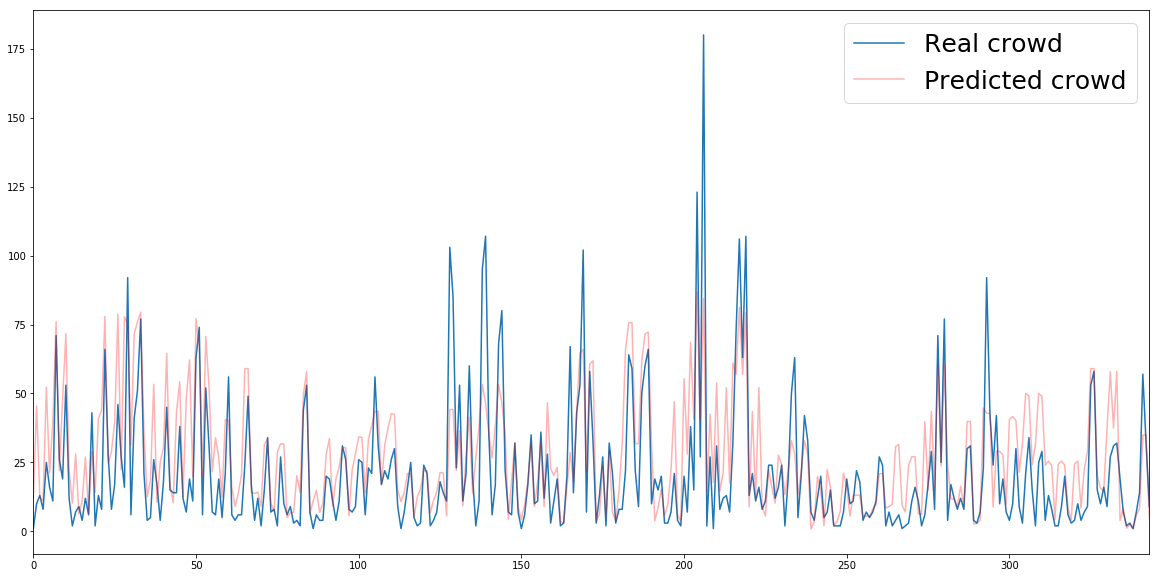

In [105]:
plt.figure(figsize=(20,10))
b.counter.plot(label='Real crowd')
(b.predicted_crowd).plot(c='red',alpha=0.3, label='Predicted crowd')
plt.legend(prop={'size': 25})

In [22]:
b[110:150]

,Halls,TehCode,time,film,predicted_crowd,day_of_week,tech,date,counter
110,220,9,7,00000000000000000000000000001683,5,5,[9],2019-04-22,5
111,220,9,3,00000000000000000000000000001683,12,6,[9],2019-04-23,2
112,220,9,4,00000000000000000000000000001683,15,6,[9],2019-04-23,3
113,220,9,5,00000000000000000000000000001683,22,6,[9],2019-04-23,24
114,220,9,6,00000000000000000000000000001683,21,6,[9],2019-04-23,21
115,220,9,7,00000000000000000000000000001683,6,6,[9],2019-04-23,2
116,220,9,3,00000000000000000000000000001683,11,7,[9],2019-04-24,4
117,220,9,4,00000000000000000000000000001683,14,7,[9],2019-04-24,7
118,220,9,5,00000000000000000000000000001683,21,7,[9],2019-04-24,18
119,220,9,6,00000000000000000000000000001683,21,7,[9],2019-04-24,14


In [106]:
mean_squared_error(b.predicted_crowd, b.counter)

306.0063342684507

In [17]:
307**(1/2)

17.52141546793523

In [17]:
for k,v in answer[0].items():
    print(k,v.shape)

00000000000000000000000000001592 (3781, 7)
00000000000000000000000000000599 (2016, 7)
00000000000000000000000000001361 (1767, 7)
00000000000000000000000000001752 (654, 7)
00000000000000000000000000001803 (1919, 7)
00000000000000000000000000001972 (1301, 7)
00000000000000000000000000002032 (699, 7)
2b554ec5b2f3a514337aa52eda2e97e8 (2610, 7)
00000000000000000000000000001683 (445, 7)
00000000000000000000000000001780 (776, 7)
00000000000000000000000000001786 (532, 7)
00000000000000000000000000000794 (1386, 7)
00000000000000000000000000001802 (422, 7)
00000000000000000000000000001953 (154, 7)
00000000000000000000000000001990 (246, 7)
00000000000000000000000000000601 (2142, 7)
00000000000000000000000000001648 (618, 7)
00000000000000000000000000001689 (457, 7)
00000000000000000000000000001991 (1308, 7)
00000000000000000000000000001454 (948, 7)


In [39]:
a[a.film == '00000000000000000000000000000599']

,date,film,counter,time,TehCode,Halls,day_of_week
10,2019-04-18,00000000000000000000000000000599,6,2,10,219,1
11,2019-04-21,00000000000000000000000000000599,49,2,10,219,4
12,2019-04-22,00000000000000000000000000000599,17,2,10,219,5
66,2019-04-19,00000000000000000000000000000599,6,2,10,219,2
67,2019-04-20,00000000000000000000000000000599,24,2,10,219,3
154,2019-04-23,00000000000000000000000000000599,4,2,10,219,6
155,2019-04-24,00000000000000000000000000000599,12,2,10,219,7


In [23]:
b.film.value_counts()

00000000000000000000000000001592    63
00000000000000000000000000000794    61
00000000000000000000000000001683    35
00000000000000000000000000001780    32
00000000000000000000000000001689    26
00000000000000000000000000001802    26
00000000000000000000000000001648    23
00000000000000000000000000001454    21
00000000000000000000000000000601     9
00000000000000000000000000001752     7
00000000000000000000000000001990     7
00000000000000000000000000001803     7
00000000000000000000000000001953     7
00000000000000000000000000001972     5
00000000000000000000000000001786     4
00000000000000000000000000001361     4
Name: film, dtype: int64

In [29]:
final_answer[(final_answer.film == '00000000000000000000000000000599') & (final_answer.time == 2) & (final_answer.Halls == 219)].head(5)

,TehCode,Halls,day_of_week,week_crowd,time,mounth_in,predicted_crowd,film
0,9,219,1,0.0,2,3.0,14.068287,00000000000000000000000000000599
0,10,219,1,0.0,2,3.0,13.904673,00000000000000000000000000000599
0,9,219,2,1.0,2,4.0,20.243269,00000000000000000000000000000599
0,10,219,2,1.0,2,4.0,20.595936,00000000000000000000000000000599
0,9,219,3,1.0,2,4.0,55.000000,00000000000000000000000000000599


In [26]:
a[a.film == '00000000000000000000000000000599']

,date,film,counter,time,TehCode,Halls,day_of_week
10,2019-04-18,00000000000000000000000000000599,6,2,10,219,1
11,2019-04-21,00000000000000000000000000000599,49,2,10,219,4
12,2019-04-22,00000000000000000000000000000599,17,2,10,219,5
66,2019-04-19,00000000000000000000000000000599,6,2,10,219,2
67,2019-04-20,00000000000000000000000000000599,24,2,10,219,3
154,2019-04-23,00000000000000000000000000000599,4,2,10,219,6
155,2019-04-24,00000000000000000000000000000599,12,2,10,219,7


In [35]:
a.film.value_counts()

00000000000000000000000000001592    63
00000000000000000000000000000794    61
00000000000000000000000000001683    35
00000000000000000000000000001780    32
00000000000000000000000000001689    26
00000000000000000000000000001802    26
00000000000000000000000000001648    23
00000000000000000000000000001454    21
00000000000000000000000000001748    13
00000000000000000000000000000601     9
00000000000000000000000000000599     7
00000000000000000000000000002037     7
00000000000000000000000000001953     7
00000000000000000000000000001752     7
00000000000000000000000000001803     7
00000000000000000000000000002018     7
00000000000000000000000000002020     7
00000000000000000000000000001990     7
00000000000000000000000000002034     5
00000000000000000000000000001972     5
00000000000000000000000000001786     4
00000000000000000000000000001361     4
00000000000000000000000000001995     1
Name: film, dtype: int64

In [66]:
a.shape

(384, 7)

In [42]:
a.head(2)

,date,film,counter,time,TehCode,Halls,day_of_week
0,2019-04-18,00000000000000000000000000001592,13,2,3,16,1
1,2019-04-18,00000000000000000000000000001592,14,4,7,210,1


In [67]:
b.shape

(357, 9)

In [43]:
b.head(2)

,Halls,TehCode,time,film,predicted_crowd,day_of_week,tech,date,counter
0,212,9,2,00000000000000000000000000001592,12.064949,1,"[3, 7, 9]",2019-04-18,1
1,212,9,5,00000000000000000000000000001592,45.453670,1,"[3, 7, 9]",2019-04-18,10


In [68]:
x = pd.merge(a,b,how='left', on=['film','time','TehCode','Halls','day_of_week'])

In [75]:
len(b.film.unique())

18

In [76]:
b

,Halls,TehCode,time,film,predicted_crowd,day_of_week,tech,date,counter
0,212,9,2,00000000000000000000000000001592,12.064949,1,"[3, 7, 9]",2019-04-18,1
1,212,9,5,00000000000000000000000000001592,45.453670,1,"[3, 7, 9]",2019-04-18,10
2,212,9,7,00000000000000000000000000001592,12.317157,1,"[3, 7, 9]",2019-04-18,13
3,212,9,2,00000000000000000000000000001592,11.015650,2,"[3, 7, 9]",2019-04-19,8
4,212,9,5,00000000000000000000000000001592,52.282828,2,"[3, 7, 9]",2019-04-19,25
5,212,9,7,00000000000000000000000000001592,21.083727,2,"[3, 7, 9]",2019-04-19,16
6,212,9,2,00000000000000000000000000001592,39.678746,3,"[3, 7, 9]",2019-04-20,11
7,212,9,5,00000000000000000000000000001592,76.071445,3,"[3, 7, 9]",2019-04-20,71
8,212,9,7,00000000000000000000000000001592,21.983361,3,"[3, 7, 9]",2019-04-20,26
9,212,9,2,00000000000000000000000000001592,47.890943,4,"[3, 7, 9]",2019-04-21,19
